<h2>How fast are Out-of-Core Algorithms? A Linear Regression Benchmark</h2>

In this notebook we demonstrate the capabilities of GraphLab Create on the basic task of linear regression, comparing it to the widely used machine learning package [scikit-learn](http://scikit-learn.org). Scikit-learn contains a wide range of machine learning algorithms with a great API and a large community supporting it. Although, most of its implementations are memory based, thus for modeling large datasets that do not fit into the memory of a single machine, one most use a subset of his data, or look to other tools that scale beyond the machine’s main memory. In this notebook we see how GraphLab Create does not suffer from this drawback, and how we can scale scikit-learn out-of-core when used in conjunction with GraphLab Create.
<br>
<br>
For this purpose we use the [airline on-time performance dataset](http://stat-computing.org/dataexpo/2009/) which has information about flight arrival/departure times for 10 years of flights in the US. This dataset has 28 features, some of which are categorical with high cardinality. We will train linear regression models to predict the actual flight time of a given flight. For demonstration, we will only use the data of year 2008.

In [1]:
import graphlab as gl

The data was previously saved on S3 in SFrame format, after removing rows with missing values, and removing the columns 'DepDelay', 'AirTime' which are highly corrolated with our target value (otherwise we would get 0 RMSE). <br>
The dataset contains ~1.5 million rows and is approximatly 42MB in SFrame format.

In [2]:
data = gl.SFrame('https://static.turi.com/datasets//airlines-2008.gl')

[INFO] This commercial license of GraphLab Create is assigned to engr@turi.com.

[INFO] Start server at: ipc:///tmp/graphlab_server-5959 - Server binary: /usr/local/lib/python2.7/dist-packages/graphlab/unity_server - Server log: /tmp/graphlab_server_1447913214.log
[INFO] GraphLab Server Version: 1.6.1


PROGRESS: Downloading https://static.turi.com/datasets//airlines-2008.gl/dir_archive.ini to /var/tmp/graphlab-alonpal/5959/a0e5f2fa-6808-43e8-86fb-207a36d49956.ini
PROGRESS: Downloading https://static.turi.com/datasets//airlines-2008.gl/objects.bin to /var/tmp/graphlab-alonpal/5959/7570509d-4e9e-4495-9418-9864e5743201.bin
PROGRESS: Downloading https://static.turi.com/datasets//airlines-2008.gl/m_f5e23f052ee2abf0.frame_idx to /var/tmp/graphlab-alonpal/5959/41ba5134-ba52-4036-9feb-2ee02a50a4e7.frame_idx
PROGRESS: Downloading https://static.turi.com/datasets//airlines-2008.gl/m_f5e23f052ee2abf0.sidx to /var/tmp/graphlab-alonpal/5959/90ac362b-037e-4ccf-88d1-c3b3dd0b9596.sidx


In order to time the training processes of GraphLab Create (GLC) and scikit-learn (SKL), and return the trained models, using the timeit module, we need to define a wrapper function for each package. <br>

<h4> GraphLab Create wrapper</h4>
Most of the features that GLC's linear regression model takes care of automatically (such as data rescaling and validation) are disabled here in order to be as close as possible to SKL's linear regression in terms of predictive performance.

In [2]:
#Wrapper function for timeit module
#Uses GraphLab Create to compute a linear regression model on the data
def GLC_linear_regression(data, model):
    #Create linear regression model and save it in model
    model.append(gl.linear_regression.create(data, 
                                             target='ActualElapsedTime',
                                             verbose=False, 
                                             solver='newton',
                                             l1_penalty=0, 
                                             l2_penalty=0,
                                             validation_set=None, 
                                             feature_rescaling=False, 
                                             max_iterations=1))

<h4> scikit-learn wrapper</h4>
Notice that SKL models expect the features and the target to be seperated. <br>
One can set copy_X=False while training SKL models to eliminate an additional data copy. This reduces memory utilization although can corrupt the training data. We encourage readers to experiment with this option.

In [4]:
import pandas as pd
from sklearn import linear_model

#Wrapper function for timeit module
#Uses Scikit-Learn to compute a linear regression model on the data
def SKL_linear_regression(features, target, model):
    #Create linear regression model and save it in model
    model.append(linear_model.LinearRegression())
    model[0].fit(features, target)

Let's define an additional function for each package that will handle timing and evaluating our models.

In [5]:
from timeit import timeit

def GLC_time_evaluate(data, time, rmse):
    #List to capture the model within the timeit function
    model = []
    
    #Time GLC linear regression training time
    time.append(timeit(lambda : GLC_linear_regression(data, model), number=1))
    
    #Save the training RMSE of the GLC model
    rmse.append(model[0].get('training_rmse'))

Before training a model in SKL on data including categorical features, we must first process these features using pandas get_dummies function which them using one-hot-encoding.

In [6]:
from sklearn.metrics import mean_squared_error

def SKL_time_evaluate(data, time, rmse):
    #Transform the data into a pandas data frame
    df = data.to_dataframe()
    
    #Split the target from the features for SKL
    target = df['ActualElapsedTime']
    features = df.drop('ActualElapsedTime', 1)
    
    #One-hot-encode categorical features
    features = pd.get_dummies(features)

    #List to capture the model within the timeit function
    model = []
    
    #Time SKL linear regression training time
    time.append(timeit(lambda : SKL_linear_regression(features, target, model), number=1))
    
    #Save the training RMSE of the GLC model
    rmse.append(mean_squared_error(target, model[0].predict(features))**0.5)

Since this encoding happens in-memory, the datasets become quite large and occupie much more memory (depending on the cardinality of the categorical features). On my 8GB machine, I could not train a linear regression model using SKL on more than 90k rows of data.
<br>
<br>
We now feed the functions training sets of increasing size, and save the training time and RMSE for each model so we can plot them later on.

In [7]:
glc_time = []
glc_rmse = []

skl_time = []
skl_rmse = []

#Time both libraries on datasets of increasing size
rows_range = range(5000, 90001, 2500)
for n_rows in rows_range:  
    #Create a new SFrame with n_rows out of the data
    sf = data.head(n_rows)
    
    #Time and evaluate GLC linear regression model
    GLC_time_evaluate(sf, glc_time, glc_rmse)
    
    #Time and evaluate SKL linear regression model
    SKL_time_evaluate(sf, skl_time, skl_rmse)

<h1> Scaling up scikit-learn</h1>
<br>
GraphLab Create provides its own numpy implementation, where numpy arrays are backed by SFrames, scaling them out-of-core. This allows running some of the scikit-learn algorithms on larger scale without having to change any code.<br>
SKL also implements SGD regressor which can be used for linear regression. Using the partial fit method, one could make it work out-of-core. The downside is that SGD is a notoriously hard algorithm to tune. Hence, getting the algorithm to obtain the same level of accuracy is challenging. We found the out-of-core numpy feature to be an easier way to implement out-of-core linear regression in SKL as we will see in later in this notebook.

In [8]:
import numpy as np
import graphlab.numpy

Scalable Numpy Activation Successful


Time scikit-learn backed by SFrame on the first 90K rows of data and save the results.

In [9]:
np_time = []
np_rmse = []

#Time skl using SFrame backed numpy arrays on datasets of increasing size
rows_range = range(5000, 90001, 2500)
for n_rows in rows_range:
    #Create a new SFrame with n_rows out of the data
    sf = data.head(n_rows)
    
    #Time and evaluate SKL linear regression model backed by SFrame
    SKL_time_evaluate(sf, np_time, np_rmse)

Let's continue increasing the size of the training set for GLC and SKL backed by SFrames. <br>
Notice that we are using the exact same code as before backing numpy arrays by SFrames, only that now we are able to train on larger datasets. 

In [10]:
rows_range = range(92500, 100001, 2500)
for n_rows in rows_range:
    #Create a new SFrame with n_rows out of the data
    sf = data.head(n_rows)
    
    #Time and evaluate GLC linear regression model
    GLC_time_evaluate(sf, glc_time, glc_rmse)
    
    #Time and evaluate SKL linear regression model backed by SFrame
    SKL_time_evaluate(sf, np_time, np_rmse)

<h1> Plotting the results</h1>


First, let's look at the RMSE of all models.

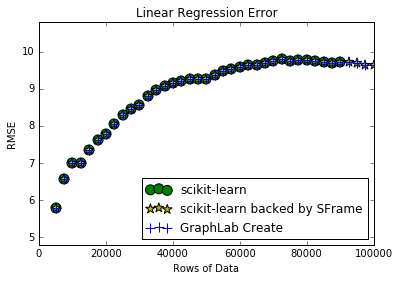

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

skl_range = np.array(range(5000, 90001, 2500))
glc_range = np.array(range(5000, 100001, 2500))

plt.figure()

plt.scatter(skl_range, skl_rmse, label='scikit-learn', c='g', marker='o', s=100)
plt.scatter(glc_range, np_rmse, label='scikit-learn backed by SFrame', c='y', marker='*', s=100)
plt.scatter(glc_range, glc_rmse, label='GraphLab Create', c='b', marker='+', s=100)

plt.title('Linear Regression Error')
plt.xlabel('Rows of Data')
plt.ylabel('RMSE')

plt.ylim((min(glc_rmse) - 1, max(glc_rmse) + 1))
plt.xlim((0, max(glc_range)))

plt.legend(loc=4)

plt.show()

We see that the RMSE of all models trained by both packages is (almost) identical. This may not be true for more comlex models, and greatly depends on different hyperparameters.

Now let's compare the training time of all models.

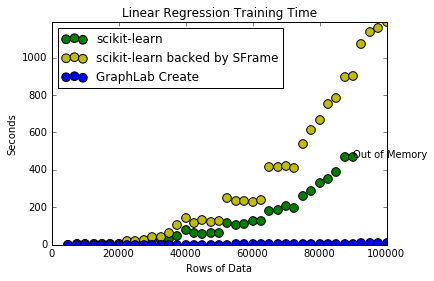

In [12]:
plt.figure()

plt.scatter(skl_range, skl_time, label='scikit-learn', c='g', marker='o', s=75)
plt.scatter(glc_range, np_time, label='scikit-learn backed by SFrame', c='y', marker='o', s=75)
plt.scatter(glc_range, glc_time, label='GraphLab Create', c='b', marker='o', s=75)

plt.annotate(s='Out of Memory', xy=(skl_range[-1], skl_time[-1]))

plt.title('Linear Regression Training Time')
plt.xlabel('Rows of Data')
plt.ylabel('Seconds')

plt.ylim((0, max(np_time)))
plt.xlim((0, max(glc_range)))

plt.legend(loc=2)

plt.show()

We see that GLC makes use of the full capacity of a desktop's computational power and scales very well with the size of the given dataset. While backing scikit-learn by SFrame, we were able to train linear regression models on datasets of increasing size, but the training time is a couple of orders of magnitude slower than that of GraphLab Create. We encourage you to download the notebook and try this benchmark for yourself on your own setup.
<br>
<br>
For completeness, let's train using GLC on the entire dataset which contains ~1.5 million rows. <br>
Note that we could do so too for SKL backed by SFrame but it would be too time consuming.

In [13]:
timeit(lambda : GLC_linear_regression(data, []), number=1)

38.17780804634094

We encourage you to download the notebook and try this benchmark for yourself on your own setup.